In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size)
        Qlogits = tf.layers.dense(inputs=states_logits, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size,
               states, actions, next_states, dones, rates):
    ################################################ s', r = env(s, a)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=states.dtype)
    e_next_states_logits, eQlogits = Env(actions=actions_labels, states=states, hidden_size=hidden_size,
                                         action_size=action_size, state_size=state_size)
    ################################################ a = act(s)
    ################################################ s', r = env(s, a)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    a_next_states_logits, aQlogits = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                         action_size=action_size, state_size=state_size, reuse=True)
    ###############################################
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, 
                                                                                 labels=next_states_labels), 
                                         axis=1))
    eloss += -tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                   labels=next_states_labels), 
                                           axis=1))
    aloss = tf.reduce_mean(tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                                 labels=next_states_labels), 
                                          axis=1))
    #################################################### MC Qlearning
    eQlogits = tf.reshape(eQlogits, shape=[-1])
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQlogits, labels=rates))
    ################################################ a' = act(s')
    ################################################ s', Q' = env(s', a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    _, nextQlogits = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                         action_size=action_size, state_size=state_size, reuse=True)
    nextQlogits = tf.reshape(nextQlogits, shape=[-1]) * (1- dones)
    eloss += tf.reduce_mean(tf.square(eQlogits - nextQlogits))
    ################################################ a = act(s)
    aQlogits = tf.reshape(aQlogits, shape=[-1])
    aloss += tf.reduce_mean(aQlogits)
    return actions_logits, aloss, eloss

In [7]:
def model_opt(a_loss, e_loss, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
    return a_opt, e_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size,
            states=self.states, actions=self.actions, next_states=self.next_states, dones=self.dones, 
            rates=self.rates)
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt = model_opt(a_loss=self.a_loss, e_loss=self.e_loss,
                                           a_learning_rate=a_learning_rate,
                                           e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
rate = -1
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset
        rate = -1 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch = [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:17.0000 R:17.0000 rate:0.0340 aloss:3.0401 eloss:1.3507 exploreP:0.9983
Episode:1 meanR:27.0000 R:37.0000 rate:0.0740 aloss:2.9859 eloss:1.2499 exploreP:0.9947
Episode:2 meanR:22.0000 R:12.0000 rate:0.0240 aloss:2.9433 eloss:1.1433 exploreP:0.9935
Episode:3 meanR:21.0000 R:18.0000 rate:0.0360 aloss:2.9597 eloss:1.2212 exploreP:0.9917
Episode:4 meanR:20.4000 R:18.0000 rate:0.0360 aloss:2.8827 eloss:1.0556 exploreP:0.9900
Episode:5 meanR:19.1667 R:13.0000 rate:0.0260 aloss:2.9017 eloss:1.0916 exploreP:0.9887
Episode:6 meanR:19.4286 R:21.0000 rate:0.0420 aloss:2.8705 eloss:1.0094 exploreP:0.9866
Episode:7 meanR:18.1250 R:9.0000 rate:0.0180 aloss:2.9014 eloss:1.1317 exploreP:0.9857
Episode:8 meanR:17.3333 R:11.0000 rate:0.0220 aloss:2.8570 eloss:1.0459 exploreP:0.9847
Episode:9 meanR:17.2000 R:16.0000 rate:0.0320 aloss:2.8535 eloss:1.0498 exploreP:0.9831
Episode:10 meanR:19.4545 R:42.0000 rate:0.0840 aloss:2.8004 eloss:0.9440 exploreP:0.9790
Episode:11 meanR:18.8333 R:12.00

Episode:93 meanR:21.7766 R:14.0000 rate:0.0280 aloss:2.1545 eloss:0.4392 exploreP:0.8167
Episode:94 meanR:21.6421 R:9.0000 rate:0.0180 aloss:2.0744 eloss:0.4784 exploreP:0.8160
Episode:95 meanR:21.5521 R:13.0000 rate:0.0260 aloss:2.1474 eloss:0.4481 exploreP:0.8150
Episode:96 meanR:21.5876 R:25.0000 rate:0.0500 aloss:2.0185 eloss:0.4480 exploreP:0.8130
Episode:97 meanR:21.5714 R:20.0000 rate:0.0400 aloss:2.0417 eloss:0.4565 exploreP:0.8114
Episode:98 meanR:21.5051 R:15.0000 rate:0.0300 aloss:2.0441 eloss:0.4771 exploreP:0.8102
Episode:99 meanR:21.5000 R:21.0000 rate:0.0420 aloss:2.0522 eloss:0.4798 exploreP:0.8085
Episode:100 meanR:21.5200 R:19.0000 rate:0.0380 aloss:2.0043 eloss:0.5011 exploreP:0.8070
Episode:101 meanR:21.2600 R:11.0000 rate:0.0220 aloss:2.0239 eloss:0.5100 exploreP:0.8061
Episode:102 meanR:21.5200 R:38.0000 rate:0.0760 aloss:1.9263 eloss:0.4988 exploreP:0.8031
Episode:103 meanR:21.5200 R:18.0000 rate:0.0360 aloss:1.8984 eloss:0.4979 exploreP:0.8016
Episode:104 meanR:

Episode:185 meanR:16.7700 R:10.0000 rate:0.0200 aloss:1.5401 eloss:0.4861 exploreP:0.7028
Episode:186 meanR:16.7900 R:14.0000 rate:0.0280 aloss:1.4768 eloss:0.4736 exploreP:0.7018
Episode:187 meanR:16.7200 R:9.0000 rate:0.0180 aloss:1.5088 eloss:0.4929 exploreP:0.7012
Episode:188 meanR:16.7300 R:25.0000 rate:0.0500 aloss:1.4393 eloss:0.5120 exploreP:0.6995
Episode:189 meanR:16.7300 R:23.0000 rate:0.0460 aloss:1.4321 eloss:0.4954 exploreP:0.6979
Episode:190 meanR:16.7000 R:11.0000 rate:0.0220 aloss:1.3782 eloss:0.5203 exploreP:0.6971
Episode:191 meanR:16.6500 R:13.0000 rate:0.0260 aloss:1.4162 eloss:0.4792 exploreP:0.6962
Episode:192 meanR:16.4200 R:10.0000 rate:0.0200 aloss:1.4173 eloss:0.4865 exploreP:0.6955
Episode:193 meanR:16.3600 R:8.0000 rate:0.0160 aloss:1.4713 eloss:0.5616 exploreP:0.6950
Episode:194 meanR:16.3700 R:10.0000 rate:0.0200 aloss:1.3872 eloss:0.4821 exploreP:0.6943
Episode:195 meanR:16.3900 R:15.0000 rate:0.0300 aloss:1.3734 eloss:0.5415 exploreP:0.6933
Episode:196 

Episode:277 meanR:15.1600 R:13.0000 rate:0.0260 aloss:1.4160 eloss:0.4594 exploreP:0.6123
Episode:278 meanR:15.2000 R:15.0000 rate:0.0300 aloss:1.3878 eloss:0.4241 exploreP:0.6114
Episode:279 meanR:15.2700 R:18.0000 rate:0.0360 aloss:1.3959 eloss:0.4388 exploreP:0.6103
Episode:280 meanR:15.2500 R:19.0000 rate:0.0380 aloss:1.3986 eloss:0.4277 exploreP:0.6092
Episode:281 meanR:15.2300 R:11.0000 rate:0.0220 aloss:1.3826 eloss:0.4231 exploreP:0.6085
Episode:282 meanR:15.1400 R:21.0000 rate:0.0420 aloss:1.3849 eloss:0.4302 exploreP:0.6073
Episode:283 meanR:15.1500 R:13.0000 rate:0.0260 aloss:1.4280 eloss:0.4356 exploreP:0.6065
Episode:284 meanR:15.1600 R:10.0000 rate:0.0200 aloss:1.4135 eloss:0.4361 exploreP:0.6059
Episode:285 meanR:15.1700 R:11.0000 rate:0.0220 aloss:1.4072 eloss:0.4569 exploreP:0.6053
Episode:286 meanR:15.1500 R:12.0000 rate:0.0240 aloss:1.3666 eloss:0.4396 exploreP:0.6046
Episode:287 meanR:15.1600 R:10.0000 rate:0.0200 aloss:1.3693 eloss:0.4420 exploreP:0.6040
Episode:28

Episode:369 meanR:13.6200 R:10.0000 rate:0.0200 aloss:1.3851 eloss:0.4103 exploreP:0.5425
Episode:370 meanR:13.6500 R:19.0000 rate:0.0380 aloss:1.3776 eloss:0.4388 exploreP:0.5414
Episode:371 meanR:13.4700 R:10.0000 rate:0.0200 aloss:1.4192 eloss:0.3933 exploreP:0.5409
Episode:372 meanR:13.5200 R:18.0000 rate:0.0360 aloss:1.4228 eloss:0.4162 exploreP:0.5400
Episode:373 meanR:13.4700 R:16.0000 rate:0.0320 aloss:1.3521 eloss:0.3832 exploreP:0.5391
Episode:374 meanR:13.6000 R:26.0000 rate:0.0520 aloss:1.4184 eloss:0.3997 exploreP:0.5377
Episode:375 meanR:13.5500 R:10.0000 rate:0.0200 aloss:1.4768 eloss:0.4237 exploreP:0.5372
Episode:376 meanR:13.5800 R:13.0000 rate:0.0260 aloss:1.3756 eloss:0.4218 exploreP:0.5365
Episode:377 meanR:13.5900 R:14.0000 rate:0.0280 aloss:1.3809 eloss:0.3869 exploreP:0.5358
Episode:378 meanR:13.6100 R:17.0000 rate:0.0340 aloss:1.3870 eloss:0.3976 exploreP:0.5349
Episode:379 meanR:13.5400 R:11.0000 rate:0.0220 aloss:1.4131 eloss:0.3969 exploreP:0.5343
Episode:38

Episode:461 meanR:12.9500 R:10.0000 rate:0.0200 aloss:1.6300 eloss:0.3380 exploreP:0.4828
Episode:462 meanR:12.9600 R:12.0000 rate:0.0240 aloss:1.5123 eloss:0.3867 exploreP:0.4822
Episode:463 meanR:12.9300 R:10.0000 rate:0.0200 aloss:1.4463 eloss:0.3941 exploreP:0.4817
Episode:464 meanR:12.9200 R:12.0000 rate:0.0240 aloss:1.5073 eloss:0.4002 exploreP:0.4812
Episode:465 meanR:12.9100 R:20.0000 rate:0.0400 aloss:1.4923 eloss:0.3958 exploreP:0.4802
Episode:466 meanR:12.9000 R:11.0000 rate:0.0220 aloss:1.5195 eloss:0.4166 exploreP:0.4797
Episode:467 meanR:12.8800 R:10.0000 rate:0.0200 aloss:1.5188 eloss:0.4126 exploreP:0.4792
Episode:468 meanR:12.8400 R:10.0000 rate:0.0200 aloss:1.4841 eloss:0.4485 exploreP:0.4788
Episode:469 meanR:12.8600 R:12.0000 rate:0.0240 aloss:1.5345 eloss:0.4097 exploreP:0.4782
Episode:470 meanR:12.8300 R:16.0000 rate:0.0320 aloss:1.5033 eloss:0.4039 exploreP:0.4775
Episode:471 meanR:12.8400 R:11.0000 rate:0.0220 aloss:1.5037 eloss:0.3929 exploreP:0.4769
Episode:47

Episode:553 meanR:12.4700 R:11.0000 rate:0.0220 aloss:1.3826 eloss:0.4055 exploreP:0.4320
Episode:554 meanR:12.2600 R:13.0000 rate:0.0260 aloss:1.3561 eloss:0.4125 exploreP:0.4315
Episode:555 meanR:12.2600 R:9.0000 rate:0.0180 aloss:1.3644 eloss:0.4045 exploreP:0.4311
Episode:556 meanR:12.2700 R:14.0000 rate:0.0280 aloss:1.3623 eloss:0.4401 exploreP:0.4305
Episode:557 meanR:12.2300 R:9.0000 rate:0.0180 aloss:1.3432 eloss:0.4262 exploreP:0.4301
Episode:558 meanR:12.2800 R:15.0000 rate:0.0300 aloss:1.3235 eloss:0.4265 exploreP:0.4295
Episode:559 meanR:12.2900 R:11.0000 rate:0.0220 aloss:1.3922 eloss:0.4064 exploreP:0.4290
Episode:560 meanR:12.2700 R:10.0000 rate:0.0200 aloss:1.3681 eloss:0.4069 exploreP:0.4286
Episode:561 meanR:12.2600 R:9.0000 rate:0.0180 aloss:1.3661 eloss:0.4232 exploreP:0.4282
Episode:562 meanR:12.2600 R:12.0000 rate:0.0240 aloss:1.3347 eloss:0.3966 exploreP:0.4277
Episode:563 meanR:12.3400 R:18.0000 rate:0.0360 aloss:1.3905 eloss:0.4244 exploreP:0.4270
Episode:564 m

Episode:645 meanR:12.0100 R:17.0000 rate:0.0340 aloss:1.5201 eloss:0.4789 exploreP:0.3877
Episode:646 meanR:11.9800 R:12.0000 rate:0.0240 aloss:1.4147 eloss:0.4361 exploreP:0.3872
Episode:647 meanR:11.9700 R:11.0000 rate:0.0220 aloss:1.4722 eloss:0.4900 exploreP:0.3868
Episode:648 meanR:11.9500 R:11.0000 rate:0.0220 aloss:1.4503 eloss:0.4743 exploreP:0.3864
Episode:649 meanR:12.0000 R:14.0000 rate:0.0280 aloss:1.4274 eloss:0.4371 exploreP:0.3859
Episode:650 meanR:12.0300 R:15.0000 rate:0.0300 aloss:1.4063 eloss:0.4429 exploreP:0.3853
Episode:651 meanR:12.0300 R:10.0000 rate:0.0200 aloss:1.4651 eloss:0.4975 exploreP:0.3849
Episode:652 meanR:12.0800 R:14.0000 rate:0.0280 aloss:1.4150 eloss:0.4756 exploreP:0.3844
Episode:653 meanR:12.1100 R:14.0000 rate:0.0280 aloss:1.4232 eloss:0.4436 exploreP:0.3839
Episode:654 meanR:12.1100 R:13.0000 rate:0.0260 aloss:1.3970 eloss:0.4653 exploreP:0.3834
Episode:655 meanR:12.1100 R:9.0000 rate:0.0180 aloss:1.4197 eloss:0.4762 exploreP:0.3830
Episode:656

Episode:737 meanR:13.3400 R:21.0000 rate:0.0420 aloss:1.4080 eloss:0.4362 exploreP:0.3435
Episode:738 meanR:13.4400 R:20.0000 rate:0.0400 aloss:1.3819 eloss:0.4355 exploreP:0.3429
Episode:739 meanR:13.5300 R:21.0000 rate:0.0420 aloss:1.4007 eloss:0.4362 exploreP:0.3422
Episode:740 meanR:13.6000 R:17.0000 rate:0.0340 aloss:1.4107 eloss:0.4316 exploreP:0.3416
Episode:741 meanR:13.6800 R:18.0000 rate:0.0360 aloss:1.3696 eloss:0.4096 exploreP:0.3410
Episode:742 meanR:13.7500 R:17.0000 rate:0.0340 aloss:1.4185 eloss:0.4143 exploreP:0.3404
Episode:743 meanR:13.8400 R:21.0000 rate:0.0420 aloss:1.4189 eloss:0.4042 exploreP:0.3397
Episode:744 meanR:13.9700 R:23.0000 rate:0.0460 aloss:1.4378 eloss:0.4296 exploreP:0.3390
Episode:745 meanR:14.0000 R:20.0000 rate:0.0400 aloss:1.4215 eloss:0.4313 exploreP:0.3383
Episode:746 meanR:14.0400 R:16.0000 rate:0.0320 aloss:1.4018 eloss:0.4144 exploreP:0.3378
Episode:747 meanR:14.1200 R:19.0000 rate:0.0380 aloss:1.4417 eloss:0.4360 exploreP:0.3372
Episode:74

Episode:828 meanR:44.0700 R:40.0000 rate:0.0800 aloss:2.8271 eloss:0.2287 exploreP:0.2279
Episode:829 meanR:44.8400 R:93.0000 rate:0.1860 aloss:2.9515 eloss:0.2382 exploreP:0.2259
Episode:830 meanR:45.3000 R:58.0000 rate:0.1160 aloss:3.1512 eloss:0.1983 exploreP:0.2247
Episode:831 meanR:45.8500 R:69.0000 rate:0.1380 aloss:3.1804 eloss:0.2797 exploreP:0.2232
Episode:832 meanR:46.0600 R:36.0000 rate:0.0720 aloss:3.0070 eloss:0.3992 exploreP:0.2224
Episode:833 meanR:46.3300 R:43.0000 rate:0.0860 aloss:2.8887 eloss:0.4462 exploreP:0.2215
Episode:834 meanR:46.3900 R:31.0000 rate:0.0620 aloss:2.8606 eloss:0.4979 exploreP:0.2209
Episode:835 meanR:46.4200 R:19.0000 rate:0.0380 aloss:2.5761 eloss:0.5448 exploreP:0.2205
Episode:836 meanR:46.5300 R:28.0000 rate:0.0560 aloss:2.6057 eloss:0.5704 exploreP:0.2199
Episode:837 meanR:46.6100 R:29.0000 rate:0.0580 aloss:2.6065 eloss:0.5298 exploreP:0.2193
Episode:838 meanR:46.6700 R:26.0000 rate:0.0520 aloss:2.4411 eloss:0.5108 exploreP:0.2187
Episode:83

Episode:920 meanR:20.1000 R:9.0000 rate:0.0180 aloss:1.6338 eloss:0.5101 exploreP:0.1968
Episode:921 meanR:19.6400 R:11.0000 rate:0.0220 aloss:1.7664 eloss:0.4741 exploreP:0.1966
Episode:922 meanR:19.1100 R:9.0000 rate:0.0180 aloss:1.7917 eloss:0.4617 exploreP:0.1965
Episode:923 meanR:18.7200 R:13.0000 rate:0.0260 aloss:1.6369 eloss:0.4366 exploreP:0.1962
Episode:924 meanR:18.2300 R:10.0000 rate:0.0200 aloss:1.8908 eloss:0.4397 exploreP:0.1960
Episode:925 meanR:17.7000 R:12.0000 rate:0.0240 aloss:1.8667 eloss:0.3833 exploreP:0.1958
Episode:926 meanR:16.9300 R:9.0000 rate:0.0180 aloss:1.4054 eloss:0.5284 exploreP:0.1956
Episode:927 meanR:16.5300 R:9.0000 rate:0.0180 aloss:1.5509 eloss:0.4813 exploreP:0.1955
Episode:928 meanR:16.2300 R:10.0000 rate:0.0200 aloss:1.5339 eloss:0.3685 exploreP:0.1953
Episode:929 meanR:15.3800 R:8.0000 rate:0.0160 aloss:1.7836 eloss:0.3533 exploreP:0.1951
Episode:930 meanR:14.8900 R:9.0000 rate:0.0180 aloss:1.6531 eloss:0.4106 exploreP:0.1950
Episode:931 mean

Episode:1012 meanR:12.9900 R:63.0000 rate:0.1260 aloss:1.6483 eloss:0.3272 exploreP:0.1754
Episode:1013 meanR:13.2800 R:38.0000 rate:0.0760 aloss:1.6844 eloss:0.3036 exploreP:0.1747
Episode:1014 meanR:14.4100 R:122.0000 rate:0.2440 aloss:1.6375 eloss:0.3346 exploreP:0.1727
Episode:1015 meanR:14.6400 R:32.0000 rate:0.0640 aloss:1.8637 eloss:0.2924 exploreP:0.1722
Episode:1016 meanR:14.8600 R:32.0000 rate:0.0640 aloss:1.6506 eloss:0.3203 exploreP:0.1717
Episode:1017 meanR:15.0800 R:32.0000 rate:0.0640 aloss:1.7303 eloss:0.2807 exploreP:0.1712
Episode:1018 meanR:15.3700 R:41.0000 rate:0.0820 aloss:1.7538 eloss:0.2643 exploreP:0.1705
Episode:1019 meanR:15.7300 R:47.0000 rate:0.0940 aloss:1.7142 eloss:0.3022 exploreP:0.1698
Episode:1020 meanR:16.2700 R:63.0000 rate:0.1260 aloss:1.7723 eloss:0.2782 exploreP:0.1688
Episode:1021 meanR:16.5400 R:38.0000 rate:0.0760 aloss:1.8314 eloss:0.3012 exploreP:0.1682
Episode:1022 meanR:16.8400 R:39.0000 rate:0.0780 aloss:1.8542 eloss:0.2803 exploreP:0.167

Episode:1103 meanR:20.4600 R:10.0000 rate:0.0200 aloss:2.1759 eloss:0.2797 exploreP:0.1492
Episode:1104 meanR:20.4400 R:8.0000 rate:0.0160 aloss:1.9913 eloss:0.2334 exploreP:0.1491
Episode:1105 meanR:20.4300 R:8.0000 rate:0.0160 aloss:2.3516 eloss:0.3065 exploreP:0.1490
Episode:1106 meanR:20.4000 R:9.0000 rate:0.0180 aloss:1.9988 eloss:0.2578 exploreP:0.1489
Episode:1107 meanR:19.9200 R:10.0000 rate:0.0200 aloss:2.1917 eloss:0.2283 exploreP:0.1487
Episode:1108 meanR:19.4100 R:11.0000 rate:0.0220 aloss:2.0186 eloss:0.2995 exploreP:0.1486
Episode:1109 meanR:19.1400 R:10.0000 rate:0.0200 aloss:2.4005 eloss:0.3250 exploreP:0.1484
Episode:1110 meanR:18.8200 R:9.0000 rate:0.0180 aloss:1.9872 eloss:0.3133 exploreP:0.1483
Episode:1111 meanR:18.6000 R:9.0000 rate:0.0180 aloss:2.0669 eloss:0.3192 exploreP:0.1482
Episode:1112 meanR:18.0700 R:10.0000 rate:0.0200 aloss:2.4105 eloss:0.2879 exploreP:0.1480
Episode:1113 meanR:17.7800 R:9.0000 rate:0.0180 aloss:2.3546 eloss:0.2904 exploreP:0.1479
Episo

Episode:1194 meanR:10.1900 R:11.0000 rate:0.0220 aloss:1.9822 eloss:0.4481 exploreP:0.1368
Episode:1195 meanR:10.2000 R:10.0000 rate:0.0200 aloss:1.9873 eloss:0.3950 exploreP:0.1367
Episode:1196 meanR:10.1800 R:10.0000 rate:0.0200 aloss:2.1090 eloss:0.4312 exploreP:0.1366
Episode:1197 meanR:10.2000 R:12.0000 rate:0.0240 aloss:1.8916 eloss:0.4010 exploreP:0.1364
Episode:1198 meanR:10.1800 R:10.0000 rate:0.0200 aloss:1.8867 eloss:0.3975 exploreP:0.1363
Episode:1199 meanR:10.1800 R:9.0000 rate:0.0180 aloss:2.5733 eloss:0.3693 exploreP:0.1362
Episode:1200 meanR:10.1800 R:9.0000 rate:0.0180 aloss:2.0268 eloss:0.3917 exploreP:0.1361
Episode:1201 meanR:10.1900 R:9.0000 rate:0.0180 aloss:1.9339 eloss:0.5332 exploreP:0.1360
Episode:1202 meanR:10.2000 R:10.0000 rate:0.0200 aloss:2.1898 eloss:0.4202 exploreP:0.1358
Episode:1203 meanR:10.1800 R:8.0000 rate:0.0160 aloss:2.1771 eloss:0.3918 exploreP:0.1357
Episode:1204 meanR:10.1900 R:9.0000 rate:0.0180 aloss:2.2536 eloss:0.3931 exploreP:0.1356
Epis

Episode:1285 meanR:11.2300 R:9.0000 rate:0.0180 aloss:2.4455 eloss:0.4497 exploreP:0.1245
Episode:1286 meanR:11.2200 R:10.0000 rate:0.0200 aloss:2.1870 eloss:0.4046 exploreP:0.1243
Episode:1287 meanR:11.2200 R:11.0000 rate:0.0220 aloss:2.3299 eloss:0.3688 exploreP:0.1242
Episode:1288 meanR:11.2300 R:13.0000 rate:0.0260 aloss:2.6765 eloss:0.4983 exploreP:0.1241
Episode:1289 meanR:11.2300 R:10.0000 rate:0.0200 aloss:2.4931 eloss:0.4031 exploreP:0.1240
Episode:1290 meanR:11.2400 R:13.0000 rate:0.0260 aloss:2.6457 eloss:0.4109 exploreP:0.1238
Episode:1291 meanR:11.2500 R:11.0000 rate:0.0220 aloss:2.6828 eloss:0.4471 exploreP:0.1237
Episode:1292 meanR:11.2900 R:14.0000 rate:0.0280 aloss:2.3937 eloss:0.4221 exploreP:0.1235
Episode:1293 meanR:11.2800 R:9.0000 rate:0.0180 aloss:2.7540 eloss:0.4289 exploreP:0.1234
Episode:1294 meanR:11.2700 R:10.0000 rate:0.0200 aloss:2.7528 eloss:0.4490 exploreP:0.1233
Episode:1295 meanR:11.2600 R:9.0000 rate:0.0180 aloss:2.3864 eloss:0.4698 exploreP:0.1232
Ep

Episode:1376 meanR:10.0100 R:10.0000 rate:0.0200 aloss:2.9045 eloss:0.3021 exploreP:0.1145
Episode:1377 meanR:10.0100 R:10.0000 rate:0.0200 aloss:2.6527 eloss:0.3913 exploreP:0.1144
Episode:1378 meanR:10.0200 R:11.0000 rate:0.0220 aloss:2.7886 eloss:0.2934 exploreP:0.1143
Episode:1379 meanR:10.0400 R:12.0000 rate:0.0240 aloss:2.5745 eloss:0.3017 exploreP:0.1141
Episode:1380 meanR:10.0300 R:10.0000 rate:0.0200 aloss:2.3298 eloss:0.3490 exploreP:0.1140
Episode:1381 meanR:10.0100 R:9.0000 rate:0.0180 aloss:2.3097 eloss:0.4433 exploreP:0.1139
Episode:1382 meanR:10.0400 R:12.0000 rate:0.0240 aloss:2.3351 eloss:0.3537 exploreP:0.1138
Episode:1383 meanR:10.0600 R:11.0000 rate:0.0220 aloss:2.8676 eloss:0.3983 exploreP:0.1137
Episode:1384 meanR:10.0400 R:9.0000 rate:0.0180 aloss:2.3053 eloss:0.4394 exploreP:0.1136
Episode:1385 meanR:10.0600 R:11.0000 rate:0.0220 aloss:3.1422 eloss:0.3879 exploreP:0.1135
Episode:1386 meanR:10.0600 R:10.0000 rate:0.0200 aloss:2.2123 eloss:0.4824 exploreP:0.1134
E

Episode:1467 meanR:12.2300 R:21.0000 rate:0.0420 aloss:2.2997 eloss:0.3436 exploreP:0.1033
Episode:1468 meanR:12.3000 R:17.0000 rate:0.0340 aloss:2.3209 eloss:0.3362 exploreP:0.1031
Episode:1469 meanR:12.3200 R:13.0000 rate:0.0260 aloss:2.6344 eloss:0.2683 exploreP:0.1030
Episode:1470 meanR:12.3900 R:16.0000 rate:0.0320 aloss:2.1642 eloss:0.3515 exploreP:0.1029
Episode:1471 meanR:12.4500 R:18.0000 rate:0.0360 aloss:1.9882 eloss:0.3479 exploreP:0.1027
Episode:1472 meanR:12.5500 R:19.0000 rate:0.0380 aloss:2.0464 eloss:0.3180 exploreP:0.1025
Episode:1473 meanR:12.6400 R:18.0000 rate:0.0360 aloss:1.9034 eloss:0.3634 exploreP:0.1024
Episode:1474 meanR:12.6600 R:12.0000 rate:0.0240 aloss:2.4348 eloss:0.3026 exploreP:0.1022
Episode:1475 meanR:12.7400 R:17.0000 rate:0.0340 aloss:2.5482 eloss:0.3083 exploreP:0.1021
Episode:1476 meanR:12.9000 R:26.0000 rate:0.0520 aloss:2.4358 eloss:0.3231 exploreP:0.1018
Episode:1477 meanR:12.9800 R:18.0000 rate:0.0360 aloss:2.3705 eloss:0.2910 exploreP:0.1017

Episode:1558 meanR:13.6100 R:8.0000 rate:0.0160 aloss:1.9997 eloss:0.6869 exploreP:0.0928
Episode:1559 meanR:13.5100 R:9.0000 rate:0.0180 aloss:2.3379 eloss:0.8728 exploreP:0.0927
Episode:1560 meanR:13.4300 R:8.0000 rate:0.0160 aloss:2.0558 eloss:0.7066 exploreP:0.0926
Episode:1561 meanR:13.2800 R:8.0000 rate:0.0160 aloss:2.4151 eloss:0.9039 exploreP:0.0926
Episode:1562 meanR:13.2400 R:10.0000 rate:0.0200 aloss:2.1077 eloss:0.6919 exploreP:0.0925
Episode:1563 meanR:13.1900 R:13.0000 rate:0.0260 aloss:2.3723 eloss:0.8332 exploreP:0.0924
Episode:1564 meanR:13.0700 R:10.0000 rate:0.0200 aloss:2.1406 eloss:0.8244 exploreP:0.0923
Episode:1565 meanR:13.0000 R:9.0000 rate:0.0180 aloss:2.1556 eloss:0.6526 exploreP:0.0922
Episode:1566 meanR:12.9300 R:8.0000 rate:0.0160 aloss:2.1395 eloss:0.5919 exploreP:0.0921
Episode:1567 meanR:12.8200 R:10.0000 rate:0.0200 aloss:2.7937 eloss:1.0084 exploreP:0.0921
Episode:1568 meanR:12.7500 R:10.0000 rate:0.0200 aloss:2.2407 eloss:0.6749 exploreP:0.0920
Episo

Episode:1649 meanR:9.6800 R:9.0000 rate:0.0180 aloss:3.2575 eloss:0.3500 exploreP:0.0858
Episode:1650 meanR:9.6800 R:10.0000 rate:0.0200 aloss:3.3386 eloss:0.2362 exploreP:0.0857
Episode:1651 meanR:9.6800 R:10.0000 rate:0.0200 aloss:2.9187 eloss:0.4839 exploreP:0.0856
Episode:1652 meanR:9.6800 R:8.0000 rate:0.0160 aloss:2.7230 eloss:0.4559 exploreP:0.0855
Episode:1653 meanR:9.6900 R:10.0000 rate:0.0200 aloss:3.0161 eloss:0.4821 exploreP:0.0855
Episode:1654 meanR:9.6900 R:10.0000 rate:0.0200 aloss:2.3505 eloss:0.4779 exploreP:0.0854
Episode:1655 meanR:9.7000 R:10.0000 rate:0.0200 aloss:2.3868 eloss:0.4900 exploreP:0.0853
Episode:1656 meanR:9.7100 R:10.0000 rate:0.0200 aloss:2.6745 eloss:0.5133 exploreP:0.0852
Episode:1657 meanR:9.7000 R:9.0000 rate:0.0180 aloss:2.7048 eloss:0.5791 exploreP:0.0852
Episode:1658 meanR:9.7000 R:8.0000 rate:0.0160 aloss:3.0428 eloss:0.5152 exploreP:0.0851
Episode:1659 meanR:9.7000 R:9.0000 rate:0.0180 aloss:2.7396 eloss:0.5563 exploreP:0.0850
Episode:1660 me

Episode:1741 meanR:9.9400 R:10.0000 rate:0.0200 aloss:1.9559 eloss:0.5169 exploreP:0.0791
Episode:1742 meanR:9.9300 R:8.0000 rate:0.0160 aloss:2.2318 eloss:0.4851 exploreP:0.0790
Episode:1743 meanR:9.9500 R:11.0000 rate:0.0220 aloss:2.0315 eloss:0.5083 exploreP:0.0790
Episode:1744 meanR:9.9400 R:10.0000 rate:0.0200 aloss:1.7263 eloss:0.5470 exploreP:0.0789
Episode:1745 meanR:9.9600 R:11.0000 rate:0.0220 aloss:1.8335 eloss:0.5338 exploreP:0.0788
Episode:1746 meanR:9.9600 R:9.0000 rate:0.0180 aloss:1.8139 eloss:0.4921 exploreP:0.0788
Episode:1747 meanR:9.9700 R:10.0000 rate:0.0200 aloss:1.7299 eloss:0.5036 exploreP:0.0787
Episode:1748 meanR:9.9500 R:8.0000 rate:0.0160 aloss:1.4071 eloss:0.5434 exploreP:0.0786
Episode:1749 meanR:9.9500 R:9.0000 rate:0.0180 aloss:2.6835 eloss:0.4412 exploreP:0.0786
Episode:1750 meanR:9.9500 R:10.0000 rate:0.0200 aloss:1.7980 eloss:0.5273 exploreP:0.0785
Episode:1751 meanR:9.9400 R:9.0000 rate:0.0180 aloss:2.1397 eloss:0.4514 exploreP:0.0785
Episode:1752 me

Episode:1833 meanR:9.7500 R:9.0000 rate:0.0180 aloss:2.1239 eloss:0.3496 exploreP:0.0732
Episode:1834 meanR:9.7300 R:9.0000 rate:0.0180 aloss:2.0583 eloss:0.3413 exploreP:0.0731
Episode:1835 meanR:9.7300 R:10.0000 rate:0.0200 aloss:2.0306 eloss:0.4041 exploreP:0.0731
Episode:1836 meanR:9.7400 R:10.0000 rate:0.0200 aloss:2.0916 eloss:0.2977 exploreP:0.0730
Episode:1837 meanR:9.7200 R:9.0000 rate:0.0180 aloss:2.2636 eloss:0.3186 exploreP:0.0730
Episode:1838 meanR:9.7200 R:9.0000 rate:0.0180 aloss:2.0905 eloss:0.3445 exploreP:0.0729
Episode:1839 meanR:9.7200 R:10.0000 rate:0.0200 aloss:2.1940 eloss:0.2910 exploreP:0.0728
Episode:1840 meanR:9.7200 R:11.0000 rate:0.0220 aloss:2.3390 eloss:0.2961 exploreP:0.0728
Episode:1841 meanR:9.7200 R:10.0000 rate:0.0200 aloss:2.0853 eloss:0.3270 exploreP:0.0727
Episode:1842 meanR:9.7400 R:10.0000 rate:0.0200 aloss:2.3810 eloss:0.2877 exploreP:0.0726
Episode:1843 meanR:9.7600 R:13.0000 rate:0.0260 aloss:2.3251 eloss:0.2793 exploreP:0.0726
Episode:1844 m

Episode:1925 meanR:9.6800 R:10.0000 rate:0.0200 aloss:2.6252 eloss:0.1831 exploreP:0.0678
Episode:1926 meanR:9.6800 R:9.0000 rate:0.0180 aloss:3.1871 eloss:0.1933 exploreP:0.0677
Episode:1927 meanR:9.6800 R:10.0000 rate:0.0200 aloss:2.9330 eloss:0.2728 exploreP:0.0677
Episode:1928 meanR:9.7000 R:11.0000 rate:0.0220 aloss:3.2641 eloss:0.2680 exploreP:0.0676
Episode:1929 meanR:9.7200 R:10.0000 rate:0.0200 aloss:3.0143 eloss:0.2949 exploreP:0.0675
Episode:1930 meanR:9.7500 R:11.0000 rate:0.0220 aloss:3.4460 eloss:0.3796 exploreP:0.0675
Episode:1931 meanR:9.7600 R:9.0000 rate:0.0180 aloss:3.2231 eloss:0.3278 exploreP:0.0674
Episode:1932 meanR:9.7900 R:12.0000 rate:0.0240 aloss:3.3632 eloss:0.5341 exploreP:0.0674
Episode:1933 meanR:9.7800 R:8.0000 rate:0.0160 aloss:3.1979 eloss:0.2963 exploreP:0.0673
Episode:1934 meanR:9.7900 R:10.0000 rate:0.0200 aloss:3.2574 eloss:0.4479 exploreP:0.0672
Episode:1935 meanR:9.7900 R:10.0000 rate:0.0200 aloss:2.9716 eloss:0.3908 exploreP:0.0672
Episode:1936 

Episode:2017 meanR:9.7100 R:9.0000 rate:0.0180 aloss:4.9147 eloss:-0.4056 exploreP:0.0628
Episode:2018 meanR:9.7100 R:10.0000 rate:0.0200 aloss:4.9225 eloss:-0.1481 exploreP:0.0628
Episode:2019 meanR:9.7000 R:11.0000 rate:0.0220 aloss:4.7625 eloss:-0.2922 exploreP:0.0627
Episode:2020 meanR:9.7100 R:10.0000 rate:0.0200 aloss:5.6039 eloss:-0.6177 exploreP:0.0627
Episode:2021 meanR:9.7200 R:11.0000 rate:0.0220 aloss:4.7259 eloss:-0.1594 exploreP:0.0626
Episode:2022 meanR:9.6900 R:9.0000 rate:0.0180 aloss:5.5553 eloss:-0.4948 exploreP:0.0626
Episode:2023 meanR:9.6900 R:9.0000 rate:0.0180 aloss:5.9734 eloss:-0.4676 exploreP:0.0625
Episode:2024 meanR:9.6900 R:9.0000 rate:0.0180 aloss:5.2536 eloss:-0.2859 exploreP:0.0625
Episode:2025 meanR:9.6900 R:10.0000 rate:0.0200 aloss:4.2450 eloss:-0.0150 exploreP:0.0624
Episode:2026 meanR:9.7000 R:10.0000 rate:0.0200 aloss:5.0133 eloss:-0.2622 exploreP:0.0624
Episode:2027 meanR:9.7100 R:11.0000 rate:0.0220 aloss:6.3560 eloss:-0.3106 exploreP:0.0623
Epi

Episode:2109 meanR:9.8000 R:9.0000 rate:0.0180 aloss:2.6477 eloss:0.6063 exploreP:0.0583
Episode:2110 meanR:9.7900 R:8.0000 rate:0.0160 aloss:2.8501 eloss:0.6254 exploreP:0.0582
Episode:2111 meanR:9.7700 R:9.0000 rate:0.0180 aloss:2.9945 eloss:0.6740 exploreP:0.0582
Episode:2112 meanR:9.7700 R:9.0000 rate:0.0180 aloss:2.7644 eloss:0.7146 exploreP:0.0581
Episode:2113 meanR:9.7700 R:9.0000 rate:0.0180 aloss:2.4903 eloss:0.6439 exploreP:0.0581
Episode:2114 meanR:9.7800 R:9.0000 rate:0.0180 aloss:2.3663 eloss:0.7107 exploreP:0.0581
Episode:2115 meanR:9.8000 R:11.0000 rate:0.0220 aloss:2.7617 eloss:0.6410 exploreP:0.0580
Episode:2116 meanR:9.8000 R:11.0000 rate:0.0220 aloss:2.5805 eloss:0.8194 exploreP:0.0580
Episode:2117 meanR:9.8100 R:10.0000 rate:0.0200 aloss:2.4461 eloss:0.6854 exploreP:0.0579
Episode:2118 meanR:9.8400 R:13.0000 rate:0.0260 aloss:2.1895 eloss:0.6653 exploreP:0.0578
Episode:2119 meanR:9.8100 R:8.0000 rate:0.0160 aloss:3.2371 eloss:0.5835 exploreP:0.0578
Episode:2120 mean

Episode:2201 meanR:9.5400 R:8.0000 rate:0.0160 aloss:2.5496 eloss:0.4627 exploreP:0.0542
Episode:2202 meanR:9.5400 R:8.0000 rate:0.0160 aloss:2.8420 eloss:0.4340 exploreP:0.0542
Episode:2203 meanR:9.5600 R:11.0000 rate:0.0220 aloss:2.3809 eloss:0.4828 exploreP:0.0541
Episode:2204 meanR:9.5500 R:10.0000 rate:0.0200 aloss:2.3776 eloss:0.4872 exploreP:0.0541
Episode:2205 meanR:9.5500 R:10.0000 rate:0.0200 aloss:2.4733 eloss:0.4333 exploreP:0.0540
Episode:2206 meanR:9.5400 R:9.0000 rate:0.0180 aloss:2.5058 eloss:0.4441 exploreP:0.0540
Episode:2207 meanR:9.5400 R:9.0000 rate:0.0180 aloss:1.9139 eloss:0.5359 exploreP:0.0540
Episode:2208 meanR:9.5200 R:9.0000 rate:0.0180 aloss:2.5091 eloss:0.4472 exploreP:0.0539
Episode:2209 meanR:9.5300 R:10.0000 rate:0.0200 aloss:2.4081 eloss:0.4592 exploreP:0.0539
Episode:2210 meanR:9.5600 R:11.0000 rate:0.0220 aloss:2.3632 eloss:0.4129 exploreP:0.0538
Episode:2211 meanR:9.5600 R:9.0000 rate:0.0180 aloss:2.5555 eloss:0.4060 exploreP:0.0538
Episode:2212 mea

Episode:2293 meanR:9.7500 R:9.0000 rate:0.0180 aloss:2.1750 eloss:0.3141 exploreP:0.0504
Episode:2294 meanR:9.7600 R:10.0000 rate:0.0200 aloss:2.7169 eloss:0.2613 exploreP:0.0504
Episode:2295 meanR:9.7700 R:9.0000 rate:0.0180 aloss:2.2903 eloss:0.2720 exploreP:0.0503
Episode:2296 meanR:9.7500 R:9.0000 rate:0.0180 aloss:2.6692 eloss:0.2454 exploreP:0.0503
Episode:2297 meanR:9.7500 R:9.0000 rate:0.0180 aloss:3.7080 eloss:0.3127 exploreP:0.0502
Episode:2298 meanR:9.7600 R:10.0000 rate:0.0200 aloss:2.2895 eloss:0.2845 exploreP:0.0502
Episode:2299 meanR:9.7800 R:10.0000 rate:0.0200 aloss:2.5749 eloss:0.2862 exploreP:0.0502
Episode:2300 meanR:9.8000 R:10.0000 rate:0.0200 aloss:2.2528 eloss:0.2881 exploreP:0.0501
Episode:2301 meanR:9.8100 R:9.0000 rate:0.0180 aloss:3.4716 eloss:0.1845 exploreP:0.0501
Episode:2302 meanR:9.8400 R:11.0000 rate:0.0220 aloss:2.2825 eloss:0.3121 exploreP:0.0500
Episode:2303 meanR:9.8400 R:11.0000 rate:0.0220 aloss:2.2333 eloss:0.3207 exploreP:0.0500
Episode:2304 me

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

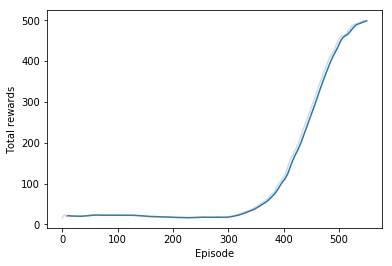

In [19]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

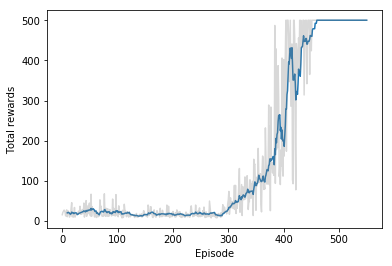

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

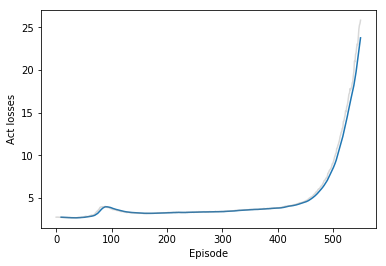

In [20]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

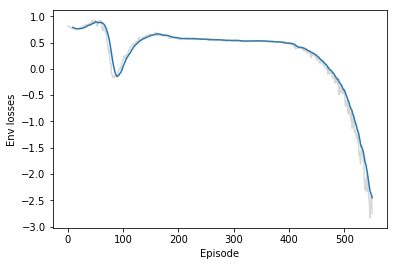

In [21]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

## Testing

Let's checkout how our trained agent plays the game.

In [23]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
